In this notebook we will be visualizing the Airbnb Boston dataset.

Part 1: Libraries to import

In [2]:
%matplotlib inline

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import folium
from folium.plugins import FastMarkerCluster
from wordcloud import WordCloud, STOPWORDS 
import gensim 
from gensim.models import Word2Vec

In [3]:
#We will be using this class for data preprocessing
class Data_Handle:
    def __init__(self,df):
        super(Data_Handle,self).__init__()
        self.df = df
        
    def remove_columns(self,df,drop_cols):
        '''
        INPUT:
        df - the pandas dataframe from which columns has to be dropped
        drop_cols = list of column names that's need to be dropped
        
        OUTPUT:
        df - dataframe with the specified columns removed
        '''
        self.df = df.drop(drop_cols,axis=1)
        return self.df
    
    def print_top_x_missing_percent_cols(self,df,top_x):
        '''
        INPUT:
        df - the pandas dataframe whose percentage of missing value for each column has
        to be printed
        top_x = top x number of columns with most missing value percentage will be
        printed
        
        '''
        null_df = df.isnull().sum().sort_values(ascending=False)
        percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
        missing_data = pd.concat([null_df, percent], axis=1, keys=['Total', 'Percent'])
        print(missing_data.head(top_x))
        return
    
    def extract_numeric(self,df,columns):
        '''
        INPUT:
        df - the pandas dataframe from which numeric values need to be
        extracted from the specified columns having comma separated cell
        values.
        columns = list of column names from which values have to be 
        extracted
        
        OUTPUT:
        df - dataframe with numeric value extracted.
        '''
        remove_commas = lambda x:''.join(str(x).split(','))
        for col in columns:
            self.df[col] = df[col].apply(remove_commas).str.extract(r'(\d+)').astype(float)
        return self.df
    
    def convert_to_binary(self,df,columns):
        '''
        INPUT:
        df - the pandas dataframe from which columns has to be converted
        to binary
        
        OUTPUT:
        df - dataframe with the specified columns converted to binary
        '''
        for col in columns:
            self.df[col] = df[col].apply(lambda x: 1 if str(x)=='t' else 0 )
        return self.df
    
    def fill_missing_col(self,df,columns,method):
        '''
        INPUT:
        df - the pandas dataframe in which the specified column's
        missing values will be filled
        columns = list of column names that's need to be filled
        method = method used to fill the missing values.
        (median,mean,mode)
        OUTPUT:
        df - dataframe with the specified columns filled.
        '''
        for col in columns:
            if method=='mode':
                self.df[col] = df[col].fillna(df[col].mode()[0])
            elif method=='median':
                self.df[col] = df[col].fillna(df[col].median()[0])
            elif method=='mean':
                self.df[col] = df[col].fillna(df[col].mean())
        
        return self.df
    
    def convert_to_category(self,df,columns):
        '''
        INPUT:
        df - the pandas dataframe in which  the columns specified
        will be converted to category variables
        columns = list of column names that's need to be converted
        
        OUTPUT:
        df - dataframe with the specified columns converted to 
        categorical variables.
        '''
        for col in columns:
            self.df = pd.concat([df.drop(col,axis=1),pd.get_dummies(df[col],drop_first=False)],axis=1)
        return self.df
    
    def list_feature_to_count(self,df,column_name,new_column_name):
        '''
        INPUT:
        df - the pandas dataframe from which the specifed column
        will be converted.
        Here a column having values as lists will be converted to
        count of values in the list
        For Ex column value x =['a','b'] this value will converted to 2
        column_name = single column name
        new_column_name = column name for the new values.
        
        OUTPUT:
        df - dataframe with the specified column converted.
        '''
        count_items_in_list = lambda x : len(x.split(',')) 
        self.df[new_column_name] = df[column_name].apply(count_items_in_list)
        self.df = df.drop(columns=[column_name])
        return self.df
            
    
    def remove_rows_missing_col(self,df,columns):
        '''
        INPUT:
        df - the pandas dataframe from which rows will be removed
        which have missing values in the specified columns
        columns = list of column names that's need to be checked
        for missing values.
        
        OUTPUT:
        df - dataframe with the rows removed
        '''
        for col in columns:
            self.df = df.dropna(col)
        return self.df

In [4]:
#Reading the csv file
df_list = pd.read_csv('listings.csv')

In [5]:
df_list.head()

id                            listing_url       scrape_id  \
0  12147973  https://www.airbnb.com/rooms/12147973  20160906204935   
1   3075044   https://www.airbnb.com/rooms/3075044  20160906204935   
2      6976      https://www.airbnb.com/rooms/6976  20160906204935   
3   1436513   https://www.airbnb.com/rooms/1436513  20160906204935   
4   7651065   https://www.airbnb.com/rooms/7651065  20160906204935   

  last_scraped                                           name  \
0   2016-09-07                     Sunny Bungalow in the City   
1   2016-09-07              Charming room in pet friendly apt   
2   2016-09-07               Mexican Folk Art Haven in Boston   
3   2016-09-07  Spacious Sunny Bedroom Suite in Historic Home   
4   2016-09-07                            Come Home to Boston   

                                             summary  \
0  Cozy, sunny, family home.  Master bedroom high...   
1  Charming and quiet room in a second floor 1910...   
2  Come stay with a friendly, middle-aged guy in ...   
3  Come experience the comforts of home away from...   
4  My comfy, clean and relaxing home is one block...   

                                               space  \
0  The house has an open and cozy feel at the sam...   
1  Small but cozy and quite room with a full size...   
2  Come stay with a friendly, middle-aged guy in ...   
3  Most places you find in Boston are small howev...   
4  Clean, attractive, private room, one block fro...   

                                         description experiences_offered  \
0  Cozy, sunny, family home.  Master bedroom high...                none   
1  Charming and quiet room in a second floor 1910...                none   
2  Come stay with a friendly, middle-aged guy in ...                none   
3  Come experience the comforts of home away from...                none   
4  My comfy, clean and relaxing home is one block...                none   

                               neighborhood_overview  ... review_scores_value  \
0  Roslindale is quiet, convenient and friendly. ...  ...                 NaN   
1  The room is in Roslindale, a diverse and prima...  ...                 9.0   
2  The LOCATION: Roslindale is a safe and diverse...  ...                10.0   
3  Roslindale is a lovely little neighborhood loc...  ...                10.0   
4  I love the proximity to downtown, the neighbor...  ...                10.0   

  requires_license license jurisdiction_names instant_bookable  \
0                f     NaN                NaN                f   
1                f     NaN                NaN                t   
2                f     NaN                NaN                f   
3                f     NaN                NaN                f   
4                f     NaN                NaN                f   

  cancellation_policy require_guest_profile_picture  \
0            moderate                             f   
1            moderate                             f   
2            moderate                             t   
3            moderate                             f   
4            flexible                             f   

  require_guest_phone_verification calculated_host_listings_count  \
0                                f                              1   
1                                f                              1   
2                                f                              1   
3                                f                              1   
4                                f                              1   

   reviews_per_month  
0                NaN  
1               1.30  
2               0.47  
3               1.00  
4               2.25  

[5 rows x 95 columns]

In [6]:
df_list.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

In [7]:
df_list.describe()

id     scrape_id       host_id  host_listings_count  \
count  3.585000e+03  3.585000e+03  3.585000e+03          3585.000000   
mean   8.440875e+06  2.016091e+13  2.492311e+07            58.902371   
std    4.500787e+06  0.000000e+00  2.292781e+07           171.119663   
min    3.353000e+03  2.016091e+13  4.240000e+03             0.000000   
25%    4.679319e+06  2.016091e+13  6.103425e+06             1.000000   
50%    8.577620e+06  2.016091e+13  1.928100e+07             2.000000   
75%    1.278953e+07  2.016091e+13  3.622147e+07             7.000000   
max    1.493346e+07  2.016091e+13  9.385411e+07           749.000000   

       host_total_listings_count  neighbourhood_group_cleansed     latitude  \
count                3585.000000                           0.0  3585.000000   
mean                   58.902371                           NaN    42.340032   
std                   171.119663                           NaN     0.024403   
min                     0.000000                           NaN    42.235942   
25%                     1.000000                           NaN    42.329995   
50%                     2.000000                           NaN    42.345201   
75%                     7.000000                           NaN    42.354685   
max                   749.000000                           NaN    42.389982   

         longitude  accommodates    bathrooms  ...  review_scores_accuracy  \
count  3585.000000   3585.000000  3571.000000  ...             2762.000000   
mean    -71.084818      3.041283     1.221647  ...                9.431571   
std       0.031565      1.778929     0.501487  ...                0.931863   
min     -71.171789      1.000000     0.000000  ...                2.000000   
25%     -71.105083      2.000000     1.000000  ...                9.000000   
50%     -71.078429      2.000000     1.000000  ...               10.000000   
75%     -71.062155      4.000000     1.000000  ...               10.000000   
max     -71.000100     16.000000     6.000000  ...               10.000000   

       review_scores_cleanliness  review_scores_checkin  \
count                2767.000000            2765.000000   
mean                    9.258041               9.646293   
std                     1.168977               0.762753   
min                     2.000000               2.000000   
25%                     9.000000               9.000000   
50%                    10.000000              10.000000   
75%                    10.000000              10.000000   
max                    10.000000              10.000000   

       review_scores_communication  review_scores_location  \
count                  2767.000000             2763.000000   
mean                      9.646549                9.414043   
std                       0.735507                0.903436   
min                       4.000000                2.000000   
25%                       9.000000                9.000000   
50%                      10.000000               10.000000   
75%                      10.000000               10.000000   
max                      10.000000               10.000000   

       review_scores_value  license  jurisdiction_names  \
count          2764.000000      0.0                 0.0   
mean              9.168234      NaN                 NaN   
std               1.011116      NaN                 NaN   
min               2.000000      NaN                 NaN   
25%               9.000000      NaN                 NaN   
50%               9.000000      NaN                 NaN   
75%              10.000000      NaN                 NaN   
max              10.000000      NaN                 NaN   

       calculated_host_listings_count  reviews_per_month  
count                     3585.000000        2829.000000  
mean                        12.733891           1.970908  
std                         29.415076           2.120561  
min                          1.000000           0.010000  
25%                          1.0000

In [8]:
df_list.dtypes

id                                    int64
listing_url                          object
scrape_id                             int64
last_scraped                         object
name                                 object
                                     ...   
cancellation_policy                  object
require_guest_profile_picture        object
require_guest_phone_verification     object
calculated_host_listings_count        int64
reviews_per_month                   float64
Length: 95, dtype: object

From the above column types, the one's with object type has to be converted to appropriate data type. We will be converting these columns as and when required to numeric or float or any other type.

Let's look at the density of Airbnb rentals in different neighborhoods

In [9]:
df_neighborhood = df_list['neighbourhood_cleansed'].value_counts()
df_neighborhood = df_neighborhood.reset_index()
temp = df_list[['neighbourhood_cleansed','latitude','longitude']].groupby(['neighbourhood_cleansed'],as_index=False).mean()
df_neighborhood.reset_index
df_neighborhood['latitude'] = temp['latitude']
df_neighborhood['longitude'] = temp['latitude']

In [10]:
column1 = 'index'
column2 = 'neighbourhood_cleansed'
m = folium.Map(location=[42.3601, -71.0589], tiles='cartodbpositron',zoom_start=11)

for i in list(df_neighborhood[column1]):
    folium.CircleMarker([float(df_neighborhood[df_neighborhood[column1]==i]['latitude']),
                   float(df_neighborhood[df_neighborhood[column1]==i]['longitude'])]
              ,popup=str(i)+": "+str(df_neighborhood[df_neighborhood[column1]==i][column2])
                 ,icon=folium.Icon(color='red', icon='info-sign')
                 ).add_to(m)
folium.Choropleth(
    geo_data='boston-neighborhoods.json',
    name='choropleth',
    data=df_neighborhood,
    columns=['index','neighbourhood_cleansed'],
    key_on='properties.Name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Density of Airbnb Homestays'
).add_to(m)
folium.LayerControl().add_to(m)
m

In [11]:
#Let's look at the above density map in a more interactive way.
latitude = df_list['latitude'].tolist()
longitude = df_list['longitude'].tolist()
locations = list(zip(latitude, longitude))

map1 = folium.Map(location=[42.3601, -71.0589], zoom_start=11.5)
FastMarkerCluster(data=locations).add_to(map1)
map1

Lets quantify the above data and plot them on graph

In [13]:
data = Data_Handle(df_list) #create of object of the Data_Handle class

In [14]:
#First we will extract numeric values from the specified columns 
#becuase they have comma separated values.
numeric_cols = ['extra_people','host_response_rate','host_acceptance_rate','price','monthly_price','weekly_price','security_deposit','cleaning_fee']
df_list = data.extract_numeric(df_list,numeric_cols)

In [15]:
dense_neighbourhood = df_list['neighbourhood_cleansed'].value_counts()
dense_neighbourhood =dense_neighbourhood.reset_index()
dense_neighbourhood =dense_neighbourhood.rename(columns={'index':'neighbourhood_cleansed','neighbourhood_cleansed':'count'})
dense_neighbourhood['percent'] = dense_neighbourhood['count'].apply(lambda x:100*x/sum(dense_neighbourhood['count']))
x=dense_neighbourhood['neighbourhood_cleansed']
y=dense_neighbourhood['count']
size =dense_neighbourhood['percent']*10
trace1 = go.Scatter(x=x,y=y,name='popular neighbourhood',mode = 'markers', 
    marker=dict( 
        size=size, 
        sizemode='area', 
        sizeref=2.*max(size)/(40.**2), 
        sizemin=4,
        color = size/10,
        showscale = True,
    ) )
layout = go.Layout(title="Number of Airbnb rentals across different Neighbourhood", legend=dict(x=0.1, y=1.1, orientation="h"))
fig = go.Figure(data=[trace1],layout=layout)
iplot(fig)

Let's look at the rental cost across different neighborhoods

In [16]:
temp2 = df_list[['neighbourhood_cleansed','price']].groupby(['neighbourhood_cleansed'],as_index=False).mean()
df_neighborhood['price'] = temp2['price']

In [17]:
m1 = folium.Map(location=[42.3601, -71.0589], tiles='cartodbpositron',zoom_start=10)


folium.Choropleth(
    geo_data='boston-neighborhoods.json',
    name='choropleth',
    data=df_neighborhood,
    columns=['index','price'],
    key_on='properties.Name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Average Price of Airbnb Homestay across different neighborhoods'
).add_to(m1)

folium.LayerControl().add_to(m1)
m1

In [20]:
#Let's look the above map in a more quantitative way
expensive_neighbourhood = df_list.groupby(['neighbourhood_cleansed']).mean()['price'].sort_values(ascending=True)
expensive_neighbourhood =expensive_neighbourhood.reset_index()
x=expensive_neighbourhood['neighbourhood_cleansed']
y=expensive_neighbourhood['price']
trace1 = go.Bar(x=y,y=x,orientation='h',marker=dict(color='#ffdc51'),name='Average price of airbnb rental neighbourhood')
layout = go.Layout(title="Average price of airbnb rentals across different neighbourhood"
                   ,legend=dict(x=0.1, y=1.1, orientation="h")
                   ,xaxis=dict(title="Average Price"),
                   yaxis=dict(title="Neighborhoods"))
fig = go.Figure(data=[trace1],layout=layout)
iplot(fig)

In [21]:
#How property type and price are related 
expensive_property = df_list.groupby(['property_type']).mean()['price'].sort_values(ascending=True)
expensive_property =expensive_property.reset_index()
x=expensive_property['property_type']
y=expensive_property['price']
trace1 = go.Bar(x=y,y=x,marker=dict(color='#ffdc51'),name='Expensive Property',orientation='h')
layout = go.Layout(title="Price distribution across property type"
                   ,legend=dict(x=0.1, y=1.1, orientation="h")
                   ,xaxis=dict(title="Average Price"),
                   yaxis=dict(title="Property Type"))
fig = go.Figure(data=[trace1],layout=layout)
iplot(fig)

In [22]:
#How room type and price are related 
expensive_room = df_list.groupby(['room_type']).mean()['price'].sort_values(ascending=False)
expensive_room =expensive_room.reset_index()
x=expensive_room['room_type']
y=expensive_room['price']
trace1 = go.Bar(x=x,y=y,marker=dict(color='#ffdc51'),name='Expensive Property')
layout = go.Layout(title="Distribution of price across room type", legend=dict(x=0.1, y=1.1, orientation="h")
                  ,xaxis=dict(title="Average Price"),
                   yaxis=dict(title="Room Type"))
fig = go.Figure(data=[trace1],layout=layout)
iplot(fig)

In [25]:
#Review scores of neighbourhood
highly_rated_neighbourhood = df_list.groupby(['neighbourhood_cleansed']).mean()['review_scores_value'].sort_values(ascending=True)
highly_rated_neighbourhood =highly_rated_neighbourhood.reset_index()
x=highly_rated_neighbourhood['neighbourhood_cleansed']
y=highly_rated_neighbourhood['review_scores_value']
trace1 = go.Bar(x=y,y=x,marker=dict(color='#ffdc51'),name='high rated neighbourhood',orientation="h")
layout = go.Layout(title="Average review scores of Neighbourhood", legend=dict(x=0.1, y=1.1, orientation="h")
                  ,xaxis=dict(title="Average Review Score"),
                   yaxis=dict(title="Neighborhoods"))
fig = go.Figure(data=[trace1],layout=layout)
iplot(fig)

Now we will do some text analysis of the reviews

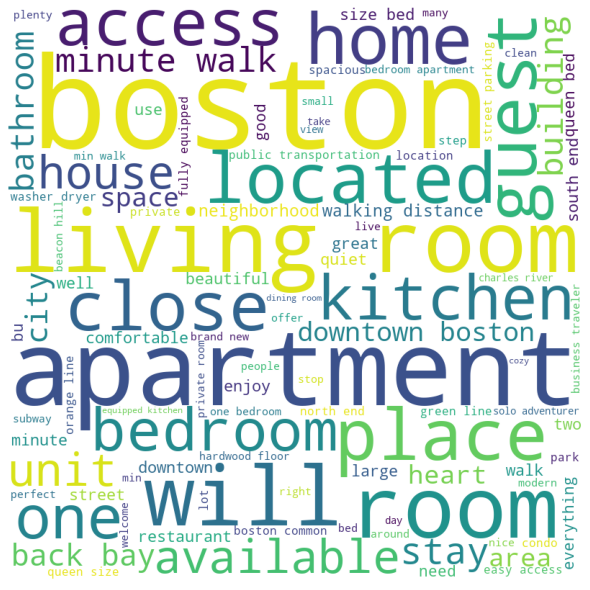

In [27]:
#Here we will visualize the most frequent words in reviews
stopwords = set(STOPWORDS)
desc_words = '' 
for desc in df_list['description']:
    desc = str(desc)
    tokens = desc.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
    desc_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords,max_words=100, 
                min_font_size = 10).generate(desc_words) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [30]:
word_list=[]
for desc in df_list['description']:
    desc = str(desc)
    tokens = desc.split() 
    word_list.append(tokens)

In [31]:
model_bow = gensim.models.Word2Vec(word_list, min_count = 1,  
                              size = 100, window = 5) 

After looking at the word cloud of most frequent words,
now we will see what are the words that are used in the context of the most frequent words

/home/sanket/anaconda3/envs/udacity/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).



For: boston


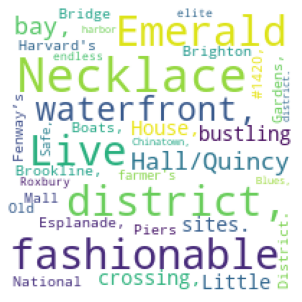

For: guest


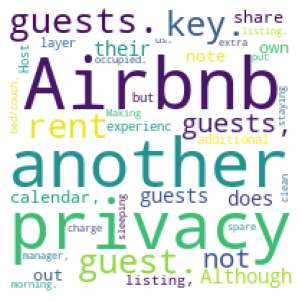

For: room


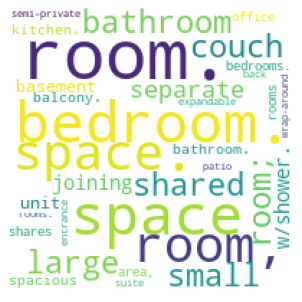

For: close


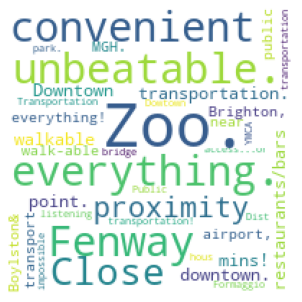

In [32]:
most_frequent=['boston','guest','room','close']
for word in most_frequent:
    d=model_bow.most_similar(word,topn=40)
    res ={}
    for x in d: 
        res[x[0]] = x[1]
    wordcloud = WordCloud(width = 200, height = 200, 
                background_color ='white', 
                stopwords = stopwords,max_words=40, 
                min_font_size = 7).generate_from_frequencies(frequencies=res) 

    # plot the WordCloud image    
    print("For:",word)
    plt.figure(figsize = (4, 4), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 